In [ ]:
#Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import shutil
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve

import keras

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import argparse

In [ ]:
#Ignoring any warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Storing all the images together in new array
data = []

#Giving image_size that is height and width each as 224
img_width, img_height = 224, 224

In [ ]:
#Appending the with_mask images into "data"
path = "Dataset/with_mask"
for img in os.listdir(path):
    pic = os.path.join(path, img)
    pic = cv2.imread(pic)
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic, (img_width, img_height))
    data.append([pic, 1])#1 for masked data
plt.show()

In [ ]:
#Total number of with_mask images
len(data)

2582

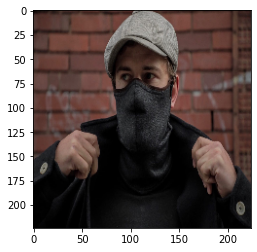

In [ ]:
#Showing sample of with_mask image
plt.imshow(np.array(data[0][0]))

In [ ]:
#Appending the without_mask images into "data"
path_1 = "Dataset/without_mask"
for img in os.listdir(path_1):
    pic = os.path.join(path_1, img)
    pic = cv2.imread(pic)
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(img_width, img_height))
    data.append([pic, 0])#0 for without masked data
plt.show()

In [ ]:
#Total number of with_mask and without_mask images
len(data)

4518

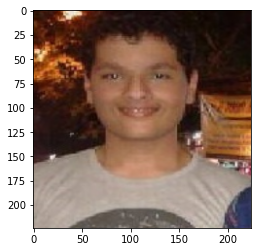

In [ ]:
#Showing sample of without_mask image
plt.imshow(np.array(data[-1][0]))

<AxesSubplot:ylabel='count'>

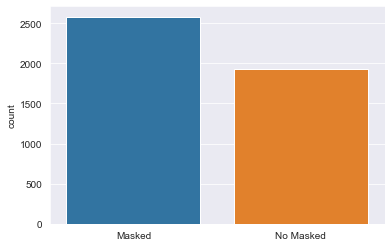

In [ ]:
# visualization of count of masked and no masked data
l = []
for i in data:
    if(i[1] == 0):
        l.append("No Masked")
    else:
        l.append("Masked")
sns.set_style('darkgrid')
sns.countplot(l)

In [ ]:
# Data preprocessing
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_width, img_height, 3)
Y = np.array(y)

In [ ]:
#Normalize the data
X = X / 255.0

In [ ]:
#Splitting the data to train and test sets to 80-20%
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state = 42)

In [ ]:
trainX.shape

(3614, 224, 224, 3)

In [ ]:
testX.shape

(904, 224, 224, 3)

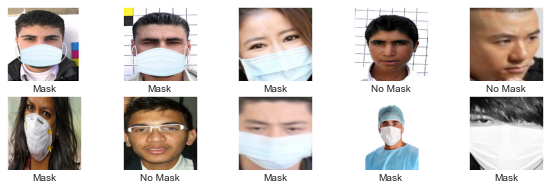

In [ ]:
#Visualization of 10 images in training dataset before data augumentation
plt.figure(figsize = (10, 3))

for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(trainX[i], cmap = plt.cm.gray_r)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if trainY[i] == 0:
      label = 'No Mask' 
    else: 
      label = 'Mask'
    l1_plot.set_xlabel(label)

In [ ]:
#Data Augumentation
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip = False)  # randomly flip images

In [ ]:
datagen.fit(trainX)

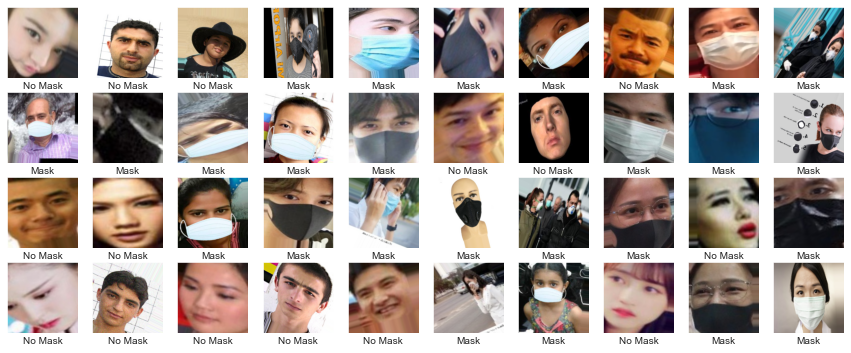

In [ ]:
#Visualization after applying data augmentation
plt.figure(figsize = (15, 6))

# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(trainX, trainY, batch_size = 40):
# create a grid of 10x2 images
  for i in range(0, 40):
    l1_plot = plt.subplot(4, 10, i + 1)
    l1_plot.imshow(X_batch[i], cmap = plt.get_cmap('gray'))
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if y_batch[i] == 0:
      label = 'No Mask' 
    else: 
      label = 'Mask'
    l1_plot.set_xlabel(label)
  # show the plot
  plt.show()
  break

In [ ]:
#Again, 80-20 split of training data for train and validations from training data

number_of_images = len(trainX)
no_of_validation_images = int(0.2 * number_of_images)

X_valid, X_train = trainX[:no_of_validation_images], trainX[no_of_validation_images:]
y_valid, y_train = trainY[:no_of_validation_images], trainY[no_of_validation_images:]

In [ ]:
# Creating Training and Validation folders in Dataset folder (One time run) 
root_dir = "Dataset"
training_path = root_dir +"/Training/"
validation_path = root_dir +"/Validation/"

if os.path.isdir(training_path):
    shutil.rmtree(training_path)

if os.path.isdir(validation_path):
    shutil.rmtree(validation_path)

os.mkdir(training_path)
os.mkdir(training_path + "with_mask/")
os.mkdir(training_path + "without_mask/")

os.mkdir(validation_path)
os.mkdir(validation_path + "with_mask/")
os.mkdir(validation_path + "without_mask/")

for i in range(len(X_train)):
    im = Image.fromarray((X_train[i] * 255).astype(np.uint8))
    if (y_train[i] == 0):
        im.save(training_path + f"without_mask/image_{i}.jpg")
    else:
        im.save(training_path + f"with_mask/image_{i}.jpg")

for i in range(len(X_valid)):
    im = Image.fromarray((X_valid[i] * 255).astype(np.uint8))
    if (y_valid[i] == 0):
        im.save(validation_path + f"without_mask/image_{i}.jpg")
    else:
        im.save(validation_path + f"with_mask/image_{i}.jpg")

print('Training: ', len(X_train))
print('Validation: ', len(X_valid))

Training:  2892
Validation:  722


### Modeling - Using pre-trained VGG16 model

In [ ]:
#Using pre-trained VGG16 model from Keras application
vgg = VGG16(input_shape = [img_width, img_height] + [3], weights='imagenet', include_top = False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Don't have to train existing weights so trainable=False.
# In Keras, each layer has a parameter called “trainable”. For freezing the weights of a particular layer, 
# we should set this parameter to False, indicating that this layer should not be trained. 
for existing_layer in vgg.layers:
    existing_layer.trainable = False
    print(existing_layer, existing_layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa340592d60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa09dcad490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa09dcadbb0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9fc1096730> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9fc10f80a0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9fc10f8d90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9fc10ffdf0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9fc1105220> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9fc110c2b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9fc1110610> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9fc10ffbe0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

### Transfer Learning on VGG16 model

In [ ]:
# Our new layers - adding at the end to the existing vgg16 model
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation = 'sigmoid')(x)

# Creating a model object
vgg16 = Model(inputs = vgg.input, outputs = prediction)

# Viewing the structure of the model
vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Using SGD as an optimizer
sgd_optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False, name="SGD")

# As its binary classification using binary_crosasentropy as the choice for the loss function.
vgg16.compile(loss= "binary_crossentropy", optimizer=sgd_optimizer, metrics=["accuracy"])
call_backs = keras.callbacks.EarlyStopping(patience=10)

#Saving the model
model_checkpoint = keras.callbacks.ModelCheckpoint("VGG16_face_mask_detection_model.h5", save_best_only=True)

In [ ]:
# training the head of the network
results = vgg16.fit_generator(datagen.flow(X_train, y_train, batch_size=100), steps_per_epoch=(len(X_train) // 100), 
                              epochs=30, callbacks=[call_backs,model_checkpoint],validation_data=(X_valid, y_valid), 
                              validation_steps=len(X_valid) // 100)

Epoch 1/30
28/28 [==============================] - 592s 21s/step - loss: 1.1978 - accuracy: 0.6641 - val_loss: 0.1398 - val_accuracy: 0.9557
Epoch 2/30
28/28 [==============================] - 446s 16s/step - loss: 0.5059 - accuracy: 0.8198 - val_loss: 0.2458 - val_accuracy: 0.9335
Epoch 3/30
28/28 [==============================] - 378s 14s/step - loss: 0.2963 - accuracy: 0.8851 - val_loss: 0.2813 - val_accuracy: 0.8726
Epoch 4/30
28/28 [==============================] - 384s 14s/step - loss: 0.2159 - accuracy: 0.9133 - val_loss: 0.1132 - val_accuracy: 0.9598
Epoch 5/30
28/28 [==============================] - 396s 14s/step - loss: 0.1346 - accuracy: 0.9476 - val_loss: 0.1086 - val_accuracy: 0.9626
Epoch 6/30
28/28 [==============================] - 361s 13s/step - loss: 0.1371 - accuracy: 0.9510 - val_loss: 0.0682 - val_accuracy: 0.9765
Epoch 7/30
28/28 [==============================] - 380s 14s/step - loss: 0.1051 - accuracy: 0.9602 - val_loss: 0.0537 - val_accuracy: 0.9792
Epoch 

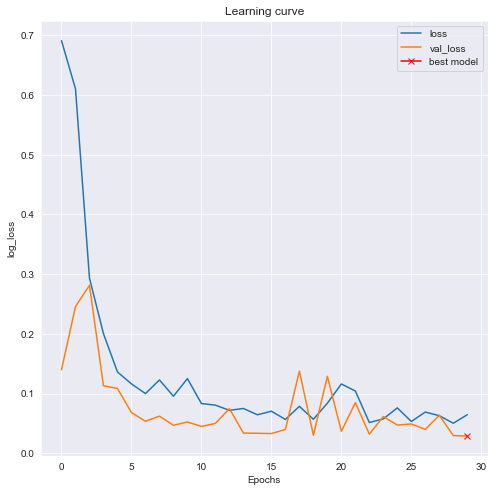

In [ ]:
# Learning curves
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
#Evaluating the model
vgg16.evaluate(testX, testY, verbose=1)

29/29 [==============================] - 113s 4s/step - loss: 0.0632 - accuracy: 0.9768


[0.06323115527629852, 0.9767699241638184]

In [ ]:
#saving the model-which can be used further
saved_final_model = keras.models.load_model("VGG16_face_mask_detection_model.h5")

In [ ]:
final_prediction = (saved_final_model.predict(testX) > 0.5).astype("int32")

#Classification-Report
class_names = ['Without mask (Class 0)','With mask (Class 1)']
class_report = classification_report(testY, final_prediction, target_names=class_names)
print("Classification Report")
print(class_report)

Classification Report
                        precision    recall  f1-score   support

Without mask (Class 0)       0.98      0.96      0.97       387
   With mask (Class 1)       0.97      0.99      0.98       517

              accuracy                           0.98       904
             macro avg       0.98      0.98      0.98       904
          weighted avg       0.98      0.98      0.98       904



In [ ]:
#Confusion Matrix
cf_matrix = confusion_matrix(testY, final_prediction)
print("Confusion Matrix")
print(cf_matrix)

Confusion Matrix
[[373  14]
 [  7 510]]


In [ ]:
#calculating Area Under the Receiver Operating Characteristic Curve (roc_auc_score)
roc_auc = roc_auc_score(testY, final_prediction)

print('ROC_AUC_Score: ',roc_auc)

ROC_AUC_Score:  0.9751423187840803


Text(0.5, 0, 'False Positive Rate')

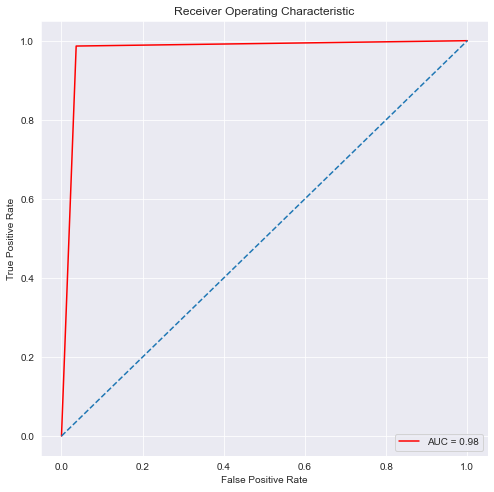

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
#calculating Accuracy, F1-score, Precision and Recall
accuracy= accuracy_score(testY, final_prediction)
f1_score = f1_score(testY, final_prediction)
precision = precision_score(testY, final_prediction)
recall = recall_score(testY, final_prediction)

print('Accuracy: ', accuracy)
print('F1-score: ', f1_score)
print('Precision: ', precision)
print('Recall: ', recall)

Accuracy:  0.9767699115044248
F1-score:  0.9798270893371757
Precision:  0.9732824427480916
Recall:  0.9864603481624759


In [ ]:
correct=[]
correct_label=[]
for i in range(len(testY)):
    if testY[i]==final_prediction[i]:
        correct.append(testX[i])
        correct_label.append(final_prediction[i])

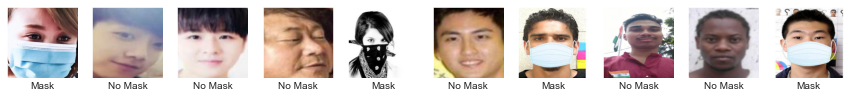

In [ ]:
plt.figure(figsize=(15, 3))

for i in range(10):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.imshow(correct[i])
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if correct_label[i]==0:
      label='No Mask' 
    else: 
      label='Mask'
    l1_plot.set_xlabel(label)

In [ ]:
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [ ]:
# Function to predict new image
def predict_image(image_name):
    image = cv2.imread(image_name)
    image = cv2.resize(image,(224,224))
    image = np.asarray(image)
    print(image.shape)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    image=np.expand_dims(image, axis=0)
    image=image/255.0
    saved_model = load_model("VGG16_face_mask_detection_model.h5")
    result = saved_model.predict(image)
    if result >= 0.5:  
         print("Predicted : Mask") 
    else: 
        print("Predicted : No Mask")

(224, 224, 3)
Predicted : Mask


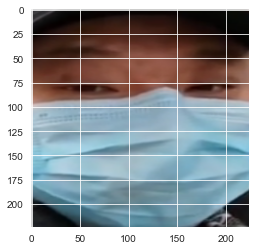

In [ ]:
predict_image("Dataset/with_mask/with_mask_3.jpg")

(224, 224, 3)
Predicted : Mask


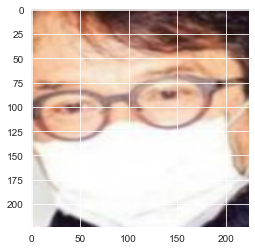

In [ ]:
predict_image("Dataset/with_mask/with_mask_4.jpg")

(224, 224, 3)
Predicted : Mask


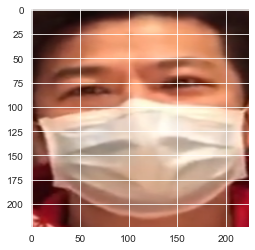

In [ ]:
predict_image("Dataset/with_mask/with_mask_5.jpg")

(224, 224, 3)
Predicted : No Mask


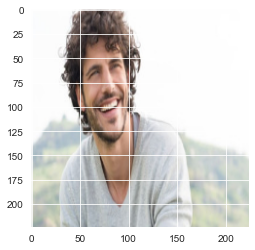

In [ ]:
predict_image("Dataset/Testing Images/testing_image_7.jpg")